# Setup

In [1]:
import os
from pathlib import Path
os.chdir(Path.cwd().parent)
# print("cwd is now:", Path.cwd())

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from data_loader import scores_df
from fit import fit_statistical_model
import statsmodels.api as sm
from scipy.stats import linregress
from scipy.optimize import least_squares
from typing import Union, Optional

null performances after coercion: 281
after saturation filter 2201
after filter num benchmarks 1401
after merge with model versions 1406
after merge with benchmark dates 1406
Original number of rows: 1406
Number of rows after aggregation: 971


# Optimized

In [32]:
anchor_mode = "model" # "model", "benchmark"
anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1
anchor_model1 = "claude-3-opus-20240229"
anchor_model1_capability = 1.510032
anchor_model2 = "claude-opus-4-20250514"
anchor_model2_capability = 2.015441	

opt_df = scores_df[scores_df['optimized']]

df_opt, df_cm_opt, df_bd_opt = fit_statistical_model(
    # scores_df,
    opt_df,
    anchor_mode=anchor_mode,
    anchor_benchmark=anchor_benchmark,
    anchor_difficulty=anchor_difficulty,
    anchor_slope=anchor_slope,
    anchor_model1=anchor_model1,
    anchor_model1_capability=anchor_model1_capability,
    anchor_model2=anchor_model2,
    anchor_model2_capability=anchor_model2_capability
)

df_cm_opt['date_obj'] = pd.to_datetime(df_cm_opt['date'])

`ftol` termination condition is satisfied.
Function evaluations 20, initial cost 3.0598e+01, final cost 1.9369e+00, first-order optimality 1.96e-04.


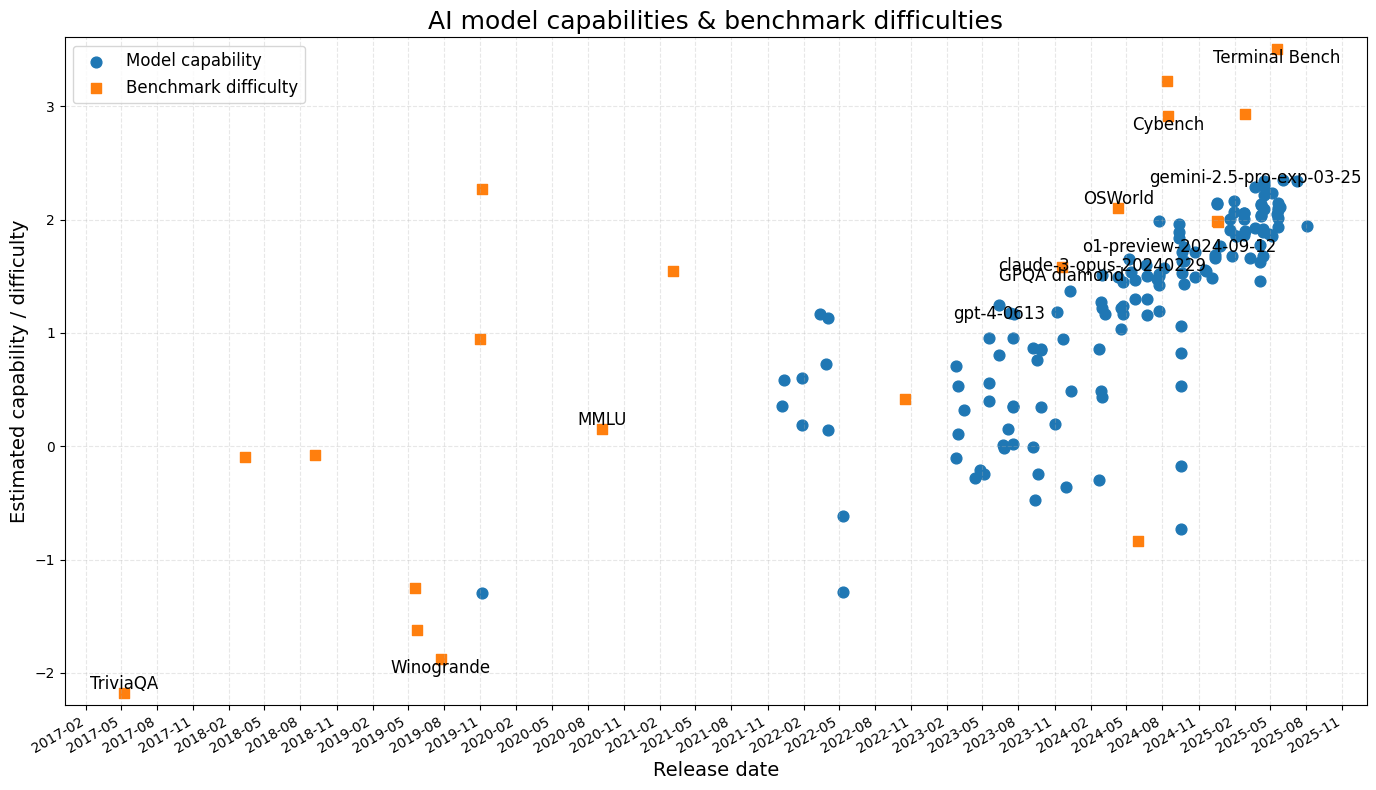

In [33]:
# ── 1)  PREP THE TWO DATA SETS ────────────────────────────────────────────
# --- models / capabilities
cap_df = df_cm_opt.copy()
cap_df["date_obj"] = pd.to_datetime(cap_df["date_obj"])
cap_df.sort_values("date_obj", inplace=True, ignore_index=True)
cap_dates_num = mdates.date2num(cap_df["date_obj"])
cap_values    = cap_df["estimated_capability"]

# --- benchmarks / difficulties
bench_df = df_bd_opt.copy()
bench_df["date_obj"] = pd.to_datetime(bench_df["benchmark_release_date"])
bench_df.sort_values("date_obj", inplace=True, ignore_index=True)
bench_dates_num = mdates.date2num(bench_df["date_obj"])
bench_values    = bench_df["estimated_difficulty"]

# ── 2)  PLOT BOTH SERIES ON ONE AXES ───────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 8))

cap_plot   = ax.scatter(cap_dates_num,   cap_values,
                        marker='o', s=60, color='tab:blue',  label='Model capability')
bench_plot = ax.scatter(bench_dates_num, bench_values,
                        marker='s', s=60, color='tab:orange', label='Benchmark difficulty')

# ── 3)  ANNOTATE SELECTED POINTS ───────────────────────────────────────────
annotate_models = {
    "gpt-4-0613",
    "claude-3-opus-20240229",
    "gemini-2.5-pro-exp-03-25",
    "o1-preview-2024-09-12",
}

for i, (d, y, name) in enumerate(zip(cap_dates_num, cap_values, cap_df["model"])):
    if name not in annotate_models:
        continue
    y_offset  = 0.05 if i % 2 == 0 else -0.05
    va        = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

annotate_benchmarks = {
    "MMLU",
    "Winogrande",
    "GPQA diamond",
    "OSWorld",
    "Cybench",
    "Terminal Bench",
    "TriviaQA",
}

for i, (d, y, name) in enumerate(zip(bench_dates_num, bench_values, bench_df["benchmark_name"])):
    if name not in annotate_benchmarks:
        continue
    y_offset  = 0.05 if i % 2 == 0 else -0.05
    va        = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

# ── 4)  AXES COSMETICS & LEGEND ────────────────────────────────────────────
ax.set_xlabel("Release date",  fontsize=14)
ax.set_ylabel("Estimated capability / difficulty", fontsize=14)
ax.set_title("AI model capabilities & benchmark difficulties", fontsize=18)

# date ticks every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
fig.autofmt_xdate()

# y-range covers both series
min_y = min(cap_values.min(),  bench_values.min()) - 0.1
max_y = max(cap_values.max(),  bench_values.max()) + 0.1
ax.set_ylim(min_y, max_y)

# x-range exactly as requested
# ax.set_xlim(datetime(2023, 1, 1), datetime(2025, 7, 1))

ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig("capabilities_and_benchmarks_over_time.pdf")
plt.show()


Bootstrapped mean rate: 0.6670 capability units/year
95% confidence interval: [0.5685, 0.7898]


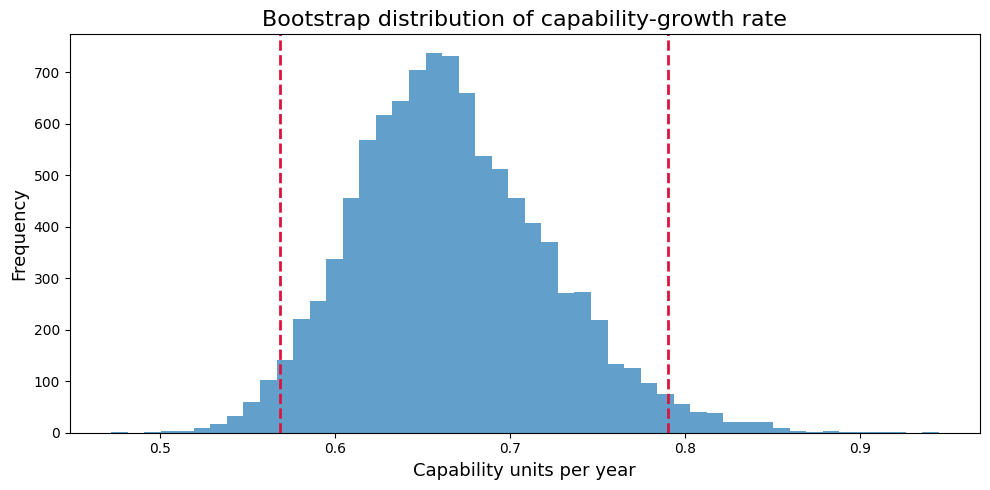

In [34]:
# ── 5) Bootstrap the slope ─────────────────────────────────────────────
import numpy as np

n_boot      = 10000          # number of bootstrap resamples
rng         = np.random.default_rng(0)   # reproducible seed

# filter out any non-finite dates/values (consistent with model_fit.ipynb)
mask  = ~(np.isnan(cap_dates_num) | np.isnan(cap_values))
x_full = cap_dates_num[mask]                       # days-since-0000-12-31 (float64)
y_full = cap_values[mask].to_numpy()               # capability values (float64)

boot_slopes_year = np.empty(n_boot)      # pre-allocate

for i in range(n_boot):
    # sample indices with replacement
    idx           = rng.choice(len(x_full), len(x_full), replace=True)
    slope_day, _  = np.polyfit(x_full[idx], y_full[idx], 1)
    boot_slopes_year[i] = slope_day * 365.25   # convert to per-year

# point estimate & 95 % CI
mean_rate = boot_slopes_year.mean()
ci_lower, ci_upper = np.percentile(boot_slopes_year, [2.5, 97.5])

print(f"Bootstrapped mean rate: {mean_rate:.4f} capability units/year")
print(f"95% confidence interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

# ── (optional) visualise the bootstrap distribution ────────────────────
plt.figure(figsize=(10, 5))
plt.hist(boot_slopes_year, bins=50, alpha=0.7)
plt.axvline(ci_lower, color='crimson', linestyle='--', lw=2)
plt.axvline(ci_upper, color='crimson', linestyle='--', lw=2)
plt.title('Bootstrap distribution of capability-growth rate', fontsize=16)
plt.xlabel('Capability units per year', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.tight_layout()
plt.show()

# Unoptimized

In [35]:

anchor_mode = "model" # "model", "benchmark"
anchor_benchmark = "Balrog"
anchor_difficulty = 2.628412
anchor_slope = 1.233816
anchor_model1 = "claude-3-opus-20240229"
anchor_model1_capability = 1.510032
anchor_model2 = "claude-opus-4-20250514"
anchor_model2_capability = 2.015441	

unopt_df = scores_df[~scores_df['optimized']]

df_unopt, df_cm_unopt, df_bd_unopt = fit_statistical_model(
    unopt_df,
    anchor_mode=anchor_mode,
    anchor_benchmark=anchor_benchmark,
    anchor_difficulty=anchor_difficulty,
    anchor_slope=anchor_slope,
    anchor_model1=anchor_model1,
    anchor_model1_capability=anchor_model1_capability,
    anchor_model2=anchor_model2,
    anchor_model2_capability=anchor_model2_capability
)

df_cm_unopt['date_obj'] = pd.to_datetime(df_cm_unopt['date'])

`ftol` termination condition is satisfied.
Function evaluations 47, initial cost 4.0998e+00, final cost 3.5839e-01, first-order optimality 3.93e-05.


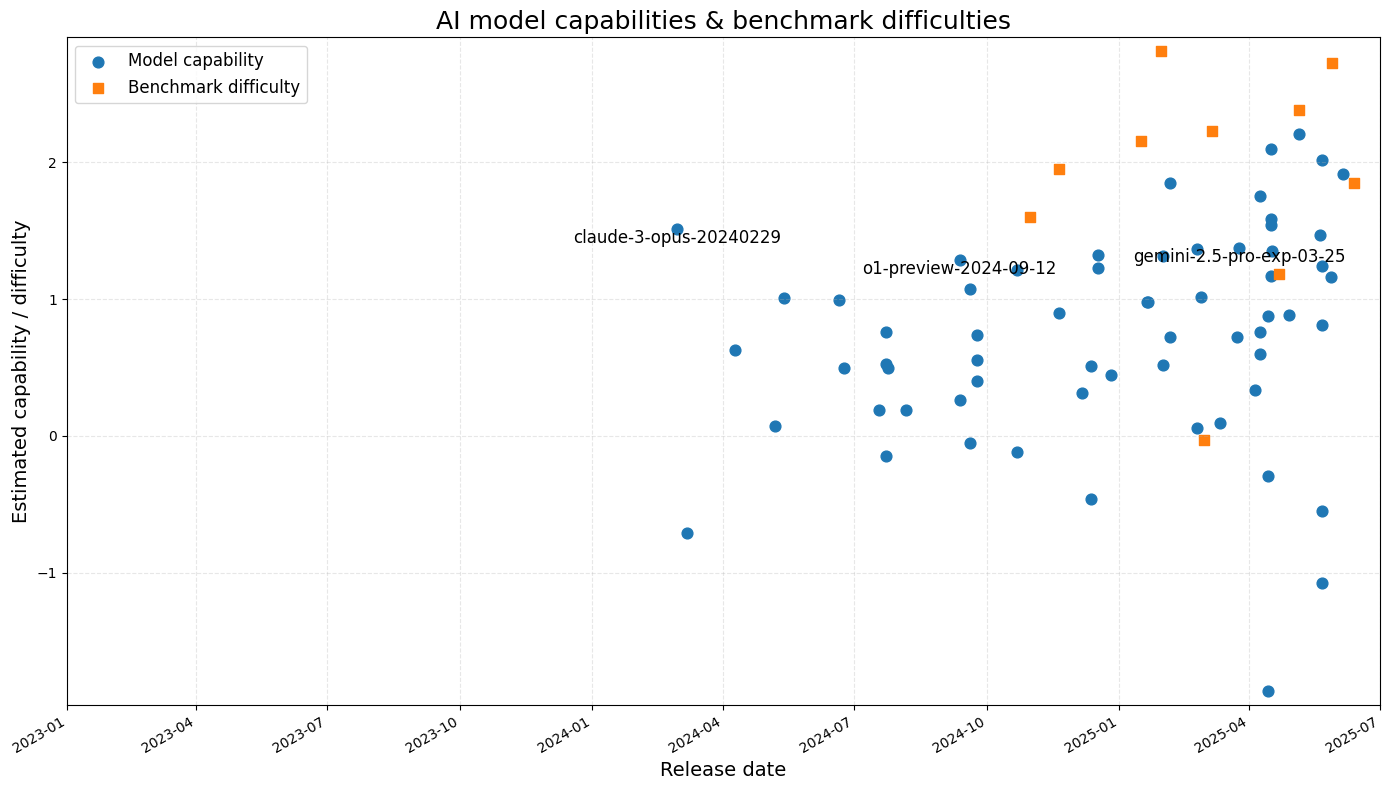

In [36]:
# ── 1)  PREP THE TWO DATA SETS ────────────────────────────────────────────
# --- models / capabilities
cap_df = df_cm_unopt.copy()
cap_df["date_obj"] = pd.to_datetime(cap_df["date_obj"])
cap_df.sort_values("date_obj", inplace=True, ignore_index=True)
cap_dates_num = mdates.date2num(cap_df["date_obj"])
cap_values    = cap_df["estimated_capability"]

# --- benchmarks / difficulties
bench_df = df_bd_unopt.copy()
bench_df["date_obj"] = pd.to_datetime(bench_df["benchmark_release_date"])
bench_df.sort_values("date_obj", inplace=True, ignore_index=True)
bench_dates_num = mdates.date2num(bench_df["date_obj"])
bench_values    = bench_df["estimated_difficulty"]

# ── 2)  PLOT BOTH SERIES ON ONE AXES ───────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 8))

cap_plot   = ax.scatter(cap_dates_num,   cap_values,
                        marker='o', s=60, color='tab:blue',  label='Model capability')
bench_plot = ax.scatter(bench_dates_num, bench_values,
                        marker='s', s=60, color='tab:orange', label='Benchmark difficulty')

# ── 3)  ANNOTATE SELECTED POINTS ───────────────────────────────────────────
annotate_models = {
    "gpt-4-0613",
    "claude-3-opus-20240229",
    "gemini-2.5-pro-exp-03-25",
    "o1-preview-2024-09-12",
}

for i, (d, y, name) in enumerate(zip(cap_dates_num, cap_values, cap_df["model"])):
    if name not in annotate_models:
        continue
    y_offset  = 0.05 if i % 2 == 0 else -0.05
    va        = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

annotate_benchmarks = {
    "MMLU",
    "Winogrande",
    "GPQA diamond",
    "OSWorld",
    "Cybench",
    "Terminal Bench",
    "TriviaQA",
}

for i, (d, y, name) in enumerate(zip(bench_dates_num, bench_values, bench_df["benchmark_name"])):
    if name not in annotate_benchmarks:
        continue
    y_offset  = 0.05 if i % 2 == 0 else -0.05
    va        = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

# ── 4)  AXES COSMETICS & LEGEND ────────────────────────────────────────────
ax.set_xlabel("Release date",  fontsize=14)
ax.set_ylabel("Estimated capability / difficulty", fontsize=14)
ax.set_title("AI model capabilities & benchmark difficulties", fontsize=18)

# date ticks every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
fig.autofmt_xdate()

# y-range covers both series
min_y = min(cap_values.min(),  bench_values.min()) - 0.1
max_y = max(cap_values.max(),  bench_values.max()) + 0.1
ax.set_ylim(min_y, max_y)

# x-range exactly as requested
ax.set_xlim(datetime(2023, 1, 1), datetime(2025, 7, 1))

ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig("capabilities_and_benchmarks_over_time.pdf")
plt.show()


Bootstrapped mean rate: 0.4115 capability units/year
95% confidence interval: [0.0622, 0.9517]


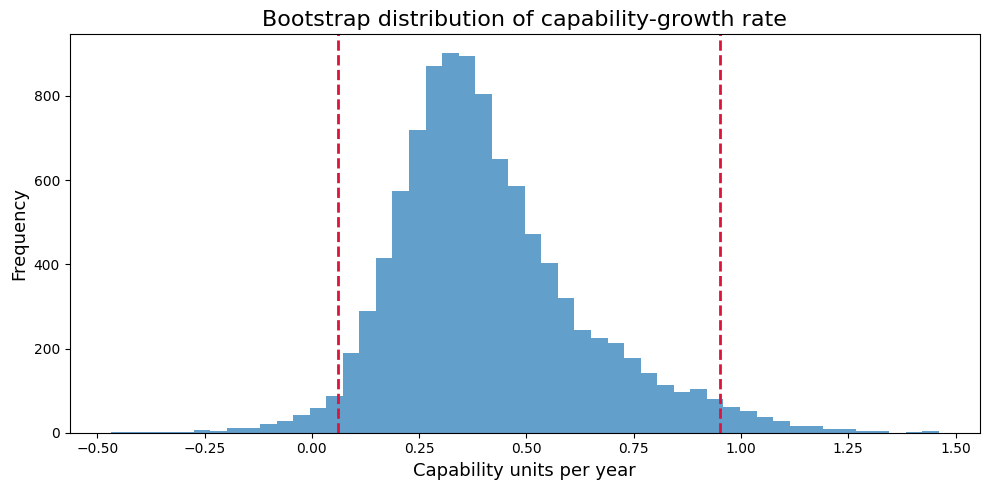

In [37]:
# ── 5) Bootstrap the slope ─────────────────────────────────────────────
n_boot      = 10000          # number of bootstrap resamples
rng         = np.random.default_rng(0)   # reproducible seed

# filter out any non-finite dates/values (consistent with model_fit.ipynb)
mask  = ~(np.isnan(cap_dates_num) | np.isnan(cap_values))
x_full = cap_dates_num[mask]                       # days-since-0000-12-31 (float64)
y_full = cap_values[mask].to_numpy()               # capability values (float64)

boot_slopes_year = np.empty(n_boot)      # pre-allocate

for i in range(n_boot):
    # sample indices with replacement
    idx           = rng.choice(len(x_full), len(x_full), replace=True)
    slope_day, _  = np.polyfit(x_full[idx], y_full[idx], 1)
    boot_slopes_year[i] = slope_day * 365.25   # convert to per-year

# point estimate & 95 % CI
mean_rate = boot_slopes_year.mean()
ci_lower, ci_upper = np.percentile(boot_slopes_year, [2.5, 97.5])

print(f"Bootstrapped mean rate: {mean_rate:.4f} capability units/year")
print(f"95% confidence interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

# ── (optional) visualise the bootstrap distribution ────────────────────
plt.figure(figsize=(10, 5))
plt.hist(boot_slopes_year, bins=50, alpha=0.7)
plt.axvline(ci_lower, color='crimson', linestyle='--', lw=2)
plt.axvline(ci_upper, color='crimson', linestyle='--', lw=2)
plt.title('Bootstrap distribution of capability-growth rate', fontsize=16)
plt.xlabel('Capability units per year', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.tight_layout()
plt.show()

# Math

`ftol` termination condition is satisfied.
Function evaluations 24, initial cost 1.1831e+01, final cost 2.8728e-01, first-order optimality 8.89e-06.


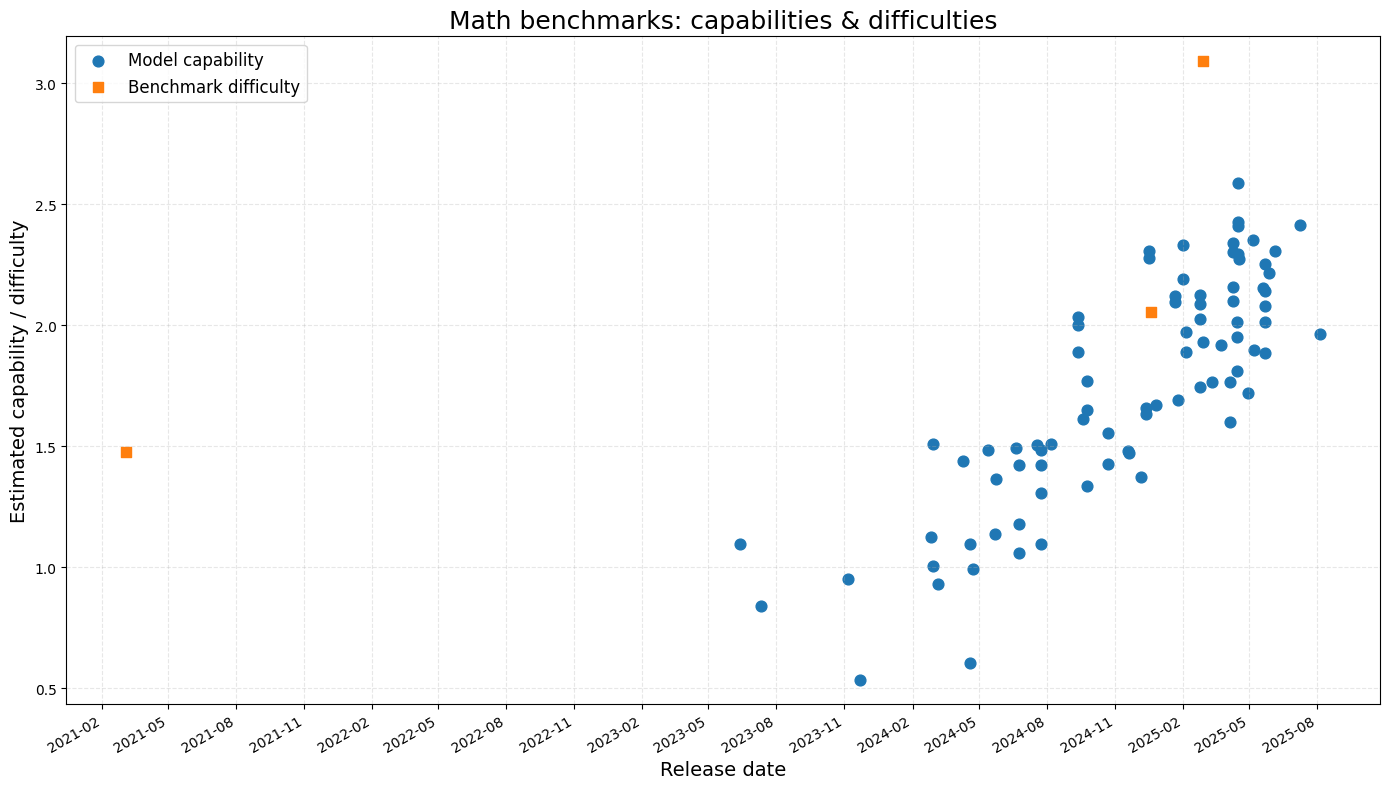

[Math] Bootstrapped mean rate: 0.8351 capability units/year
[Math] 95% confidence interval: [0.7066, 0.9757]


In [9]:
# Math trend (benchmarks flagged as is_math)
anchor_mode = "model"  # keep consistent anchoring with prior sections
anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1
anchor_model1 = "claude-3-opus-20240229"
anchor_model1_capability = 1.510032
anchor_model2 = "claude-opus-4-20250514"
anchor_model2_capability = 2.015441

math_df = scores_df[scores_df['is_math']]

if len(math_df) < 10:
    print(f"Too few rows in math_df: {len(math_df)}; skipping fit")
else:
    df_math, df_cm_math, df_bd_math = fit_statistical_model(
        math_df,
        anchor_mode=anchor_mode,
        anchor_benchmark=anchor_benchmark,
        anchor_difficulty=anchor_difficulty,
        anchor_slope=anchor_slope,
        anchor_model1=anchor_model1,
        anchor_model1_capability=anchor_model1_capability,
        anchor_model2=anchor_model2,
        anchor_model2_capability=anchor_model2_capability
    )

    # Dates for plotting
    df_cm_math['date_obj'] = pd.to_datetime(df_cm_math['date'])

    # Prep series
    cap_df = df_cm_math.copy()
    cap_df["date_obj"] = pd.to_datetime(cap_df["date_obj"])
    cap_df.sort_values("date_obj", inplace=True, ignore_index=True)
    cap_dates_num = mdates.date2num(cap_df["date_obj"])
    cap_values    = cap_df["estimated_capability"]

    bench_df = df_bd_math.copy()
    bench_df["date_obj"] = pd.to_datetime(bench_df["benchmark_release_date"])
    bench_df.sort_values("date_obj", inplace=True, ignore_index=True)
    bench_dates_num = mdates.date2num(bench_df["date_obj"])
    bench_values    = bench_df["estimated_difficulty"]

    # Plot
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.scatter(cap_dates_num, cap_values, marker='o', s=60, color='tab:blue', label='Model capability')
    ax.scatter(bench_dates_num, bench_values, marker='s', s=60, color='tab:orange', label='Benchmark difficulty')

    ax.set_xlabel("Release date", fontsize=14)
    ax.set_ylabel("Estimated capability / difficulty", fontsize=14)
    ax.set_title("Math benchmarks: capabilities & difficulties", fontsize=18)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    fig.autofmt_xdate()

    min_y = min(cap_values.min(), bench_values.min()) - 0.1
    max_y = max(cap_values.max(), bench_values.max()) + 0.1
    ax.set_ylim(min_y, max_y)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig("capabilities_and_benchmarks_over_time_math.pdf")
    plt.show()

    # Bootstrap slope on capability trend
    mask  = ~(np.isnan(cap_dates_num) | np.isnan(cap_values))
    x_full = cap_dates_num[mask]
    y_full = cap_values[mask].to_numpy()

    n_boot = 10000
    rng = np.random.default_rng(0)
    boot_slopes_year = np.empty(n_boot)
    for i in range(n_boot):
        idx = rng.choice(len(x_full), len(x_full), replace=True)
        slope_day, _ = np.polyfit(x_full[idx], y_full[idx], 1)
        boot_slopes_year[i] = slope_day * 365.25

    mean_rate = boot_slopes_year.mean()
    ci_lower, ci_upper = np.percentile(boot_slopes_year, [2.5, 97.5])
    print(f"[Math] Bootstrapped mean rate: {mean_rate:.4f} capability units/year")
    print(f"[Math] 95% confidence interval: [{ci_lower:.4f}, {ci_upper:.4f}]")


# Programming

`ftol` termination condition is satisfied.
Function evaluations 23, initial cost 3.8608e+00, final cost 1.7217e-01, first-order optimality 3.92e-05.


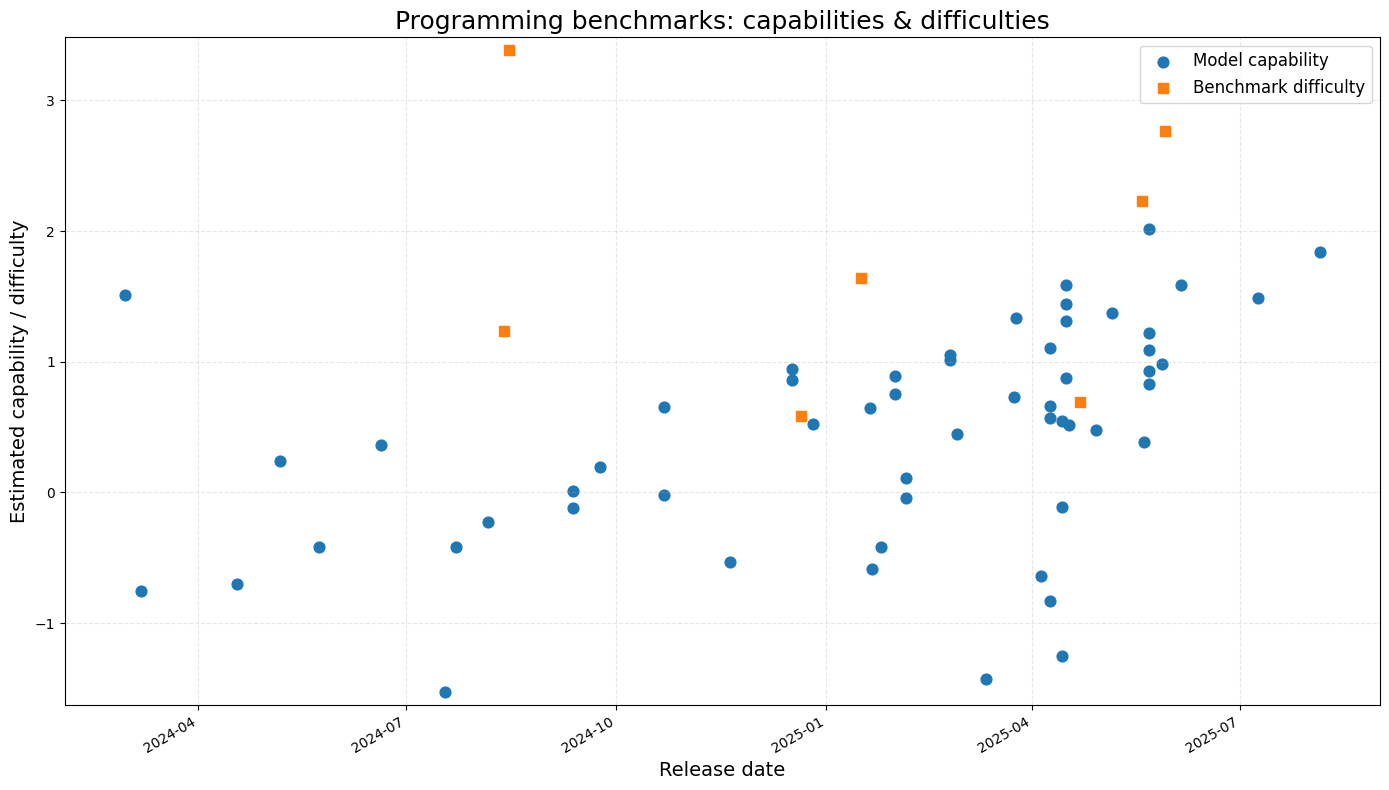

[Coding] Bootstrapped mean rate: 1.0895 capability units/year
[Coding] 95% confidence interval: [0.4192, 1.7154]


In [10]:
# Programming trend (benchmarks flagged as is_coding)
anchor_mode = "model"
anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1
anchor_model1 = "claude-3-opus-20240229"
anchor_model1_capability = 1.510032
anchor_model2 = "claude-opus-4-20250514"
anchor_model2_capability = 2.015441

coding_df = scores_df[scores_df['is_coding']]

if len(coding_df) < 10:
    print(f"Too few rows in coding_df: {len(coding_df)}; skipping fit")
else:
    df_code, df_cm_code, df_bd_code = fit_statistical_model(
        coding_df,
        anchor_mode=anchor_mode,
        anchor_benchmark=anchor_benchmark,
        anchor_difficulty=anchor_difficulty,
        anchor_slope=anchor_slope,
        anchor_model1=anchor_model1,
        anchor_model1_capability=anchor_model1_capability,
        anchor_model2=anchor_model2,
        anchor_model2_capability=anchor_model2_capability
    )

    # Dates for plotting
    df_cm_code['date_obj'] = pd.to_datetime(df_cm_code['date'])

    # Prep series
    cap_df = df_cm_code.copy()
    cap_df["date_obj"] = pd.to_datetime(cap_df["date_obj"])
    cap_df.sort_values("date_obj", inplace=True, ignore_index=True)
    cap_dates_num = mdates.date2num(cap_df["date_obj"])
    cap_values    = cap_df["estimated_capability"]

    bench_df = df_bd_code.copy()
    bench_df["date_obj"] = pd.to_datetime(bench_df["benchmark_release_date"])
    bench_df.sort_values("date_obj", inplace=True, ignore_index=True)
    bench_dates_num = mdates.date2num(bench_df["date_obj"])
    bench_values    = bench_df["estimated_difficulty"]

    # Plot
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.scatter(cap_dates_num, cap_values, marker='o', s=60, color='tab:blue', label='Model capability')
    ax.scatter(bench_dates_num, bench_values, marker='s', s=60, color='tab:orange', label='Benchmark difficulty')

    ax.set_xlabel("Release date", fontsize=14)
    ax.set_ylabel("Estimated capability / difficulty", fontsize=14)
    ax.set_title("Programming benchmarks: capabilities & difficulties", fontsize=18)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    fig.autofmt_xdate()

    min_y = min(cap_values.min(), bench_values.min()) - 0.1
    max_y = max(cap_values.max(), bench_values.max()) + 0.1
    ax.set_ylim(min_y, max_y)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig("capabilities_and_benchmarks_over_time_coding.pdf")
    plt.show()

    # Bootstrap slope on capability trend
    import numpy as np
    mask  = ~(np.isnan(cap_dates_num) | np.isnan(cap_values))
    x_full = cap_dates_num[mask]
    y_full = cap_values[mask].to_numpy()

    n_boot = 10000
    rng = np.random.default_rng(0)
    boot_slopes_year = np.empty(n_boot)
    for i in range(n_boot):
        idx = rng.choice(len(x_full), len(x_full), replace=True)
        slope_day, _ = np.polyfit(x_full[idx], y_full[idx], 1)
        boot_slopes_year[i] = slope_day * 365.25

    mean_rate = boot_slopes_year.mean()
    ci_lower, ci_upper = np.percentile(boot_slopes_year, [2.5, 97.5])
    print(f"[Coding] Bootstrapped mean rate: {mean_rate:.4f} capability units/year")
    print(f"[Coding] 95% confidence interval: [{ci_lower:.4f}, {ci_upper:.4f}]")
